In [1]:
import numpy as np
import scipy

import bayesbay as bb
from espresso import SurfaceWaveTomography
import cofi

# Imports for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.patches import PathPatch
import matplotlib.tri as tri
import cartopy.crs as ccrs
from cartopy.mpl.patch import geos_to_path

from shapely import Polygon, Point, box
from seislib.tomography import EqualAreaGrid
from seislib.utils import scatter_to_mesh
from seislib.plotting import make_colorbar
import seislib.colormaps as scm

# Data and Likelihood

In [2]:
def _forward(kdtree, vel):
    global jacobian, grid_points
    nearest_neighbors = kdtree.query(grid_points)[1]
    interp_vel = vel[nearest_neighbors]
    return interp_vel, jacobian @ (1 / interp_vel)


def forward(state):
    voronoi = state["voronoi"]
    kdtree = voronoi.load_from_cache('kdtree')
    interp_vel, d_pred = _forward(kdtree, voronoi.get_param_values('vel'))
    state.save_to_extra_storage('interp_vel', interp_vel)
    return d_pred




aus_dict = SurfaceWaveTomography(example_number=3).example_dict
grid_points = np.column_stack(aus_dict['grid'].midpoints_lon_lat())
jacobian = aus_dict['jacobian']
polygon = Polygon(aus_dict['polygon'])

d_obs = 1000 * aus_dict['slowness']
target = bb.Target('d_obs', 
                   d_obs, 
                   std_min=0, 
                   std_max=0.01, 
                   std_perturb_std=0.001,
                   noise_is_correlated=False)
log_likelihood = bb.LogLikelihood(targets=target, fwd_functions=forward)

# Parameterization

In [3]:
vel = bb.prior.UniformPrior('vel', vmin=2, vmax=4, perturb_std=0.1)
voronoi = bb.discretization.Voronoi2D(
    name='voronoi', 
    polygon=polygon, 
    perturb_std=1, 
    n_dimensions_min=100, 
    n_dimensions_max=1500, 
    parameters=[vel], 
    compute_kdtree=True)
parameterization = bb.parameterization.Parameterization(voronoi)

# Bayesian Sampling

In [4]:
n_chains = 12
starting_states = []
for _ in range(n_chains):
    starting_states.append(parameterization.initialize())
    log_likelihood.initialize(starting_states[-1])
perturbation_funcs = parameterization.perturbation_functions


inv_options = cofi.InversionOptions()
inv_options.set_tool("bayesbay")
inv_options.set_params(
    walkers_starting_states=starting_states,
    perturbation_funcs=perturbation_funcs,
    log_like_ratio_func=log_likelihood,
    n_chains=n_chains, 
    n_iterations=350_000, 
    burnin_iterations=150_000,
    verbose=False, 
    save_every=100, 
)

inv = cofi.Inversion(cofi.BaseProblem(), inv_options)
inv_results = inv.run()

In [5]:
# Get the results
saved_states = inv_results.models
statistics = {"mean": np.mean(saved_states['interp_vel'], axis=0),
              "std": np.std(saved_states['interp_vel'], axis=0),
              "std_noise": saved_states['d_obs.std']}

# Plotting

In [6]:
def plot_tessellation_geographic(voronoi_sites, 
                                 param_values=None, 
                                 clip_polygon=None, 
                                 ax=None, 
                                 colorbar=True, 
                                 vmin=None, 
                                 vmax=None, 
                                 norm=None, 
                                 cmap='viridis'):
    """
    Plots a Voronoi tessellation within a specified geographic polygon.
    
    :param voronoi_sites: Coordinates of the Voronoi sites.
    :param param_values: Parameter values for coloring the Voronoi cells.
    :param clip_polygon: The geographic boundary to clip the Voronoi tessellation.
    :param ax: The matplotlib axis to plot on. Creates a new axis if None.
    :param colorbar: Flag to indicate if a colorbar should be plotted.
    :param vmin: The minimum value for the colormap normalization.
    :param vmax: The maximum value for the colormap normalization.
    :param norm: A matplotlib.colors.Normalize instance for normalizing the color mapping.
    :param cmap: The colormap for the Voronoi cells.
    :return: The matplotlib axis and colorbar (if created).
    """
    # Extend the Voronoi sites with boundary points to enclose the tessellation.
    boundary_points = np.array([[180, 90], [-180, 90], [180, -90], [-180, -90]])
    sites = np.append(voronoi_sites, boundary_points, axis=0)
    vor = scipy.spatial.Voronoi(sites)

    # Sort and map the parameter values to the original Voronoi sites.
    if param_values is not None:
        isort = [np.flatnonzero(np.all(p == vor.points, axis=1)).item() for p in voronoi_sites]
        param_values = param_values[isort]
        vmin = vmin or min(param_values)
        vmax = vmax or max(param_values)
        norm = norm or mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        cmap = mpl.cm.get_cmap(cmap) if isinstance(cmap, str) else cmap
        colors = cmap(norm(param_values))
    else:
        colors = None

    # Configure the map projection and axis.
    proj = ccrs.LambertConformal(central_longitude=135, 
                                 central_latitude=-27, 
                                 cutoff=30, 
                                 standard_parallels=(-18, -36))
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': proj})

    # Plot the Voronoi cells, clipped by the specified polygon.
    for ipoint, iregion in enumerate(vor.point_region):
        region = vor.regions[iregion]
        if -1 not in region and region:
            polygon = Polygon([vor.vertices[i] for i in region])
            color = colors[ipoint] if colors is not None else 'none'
            plot_polygon(ax, polygon, clip_polygon, color)

    # Add a colorbar if requested.
    cbar = plot_colorbar(ax, cmap, norm) if colorbar and param_values is not None else None

    return ax, cbar

def plot_polygon(ax, polygon, clip_polygon, color):
    """
    Clips a Voronoi polygon to the specified geographic boundary and plots it.
    """
    if clip_polygon is not None:
        polygon = polygon.intersection(clip_polygon)
        if polygon.is_empty:
            return
        polygons = [polygon] if isinstance(polygon, Polygon) else polygon.geoms
    else:
        polygons = [polygon]

    for geom in polygons:
        ax.add_geometries([geom], crs=ccrs.PlateCarree(), facecolor=color, edgecolor='black', lw=0.5)

def plot_colorbar(ax, cmap, norm):
    """
    Adds a colorbar to the plot.
    """
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Dummy array for scalar mappable
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    return cbar

In [7]:
grid_coarse = EqualAreaGrid(cell_size=0.35,
                            lonmin=110,
                            lonmax=157,
                            latmin=-48,
                            latmax=-4,
                            verbose=False)
idx_in_polygon = grid_coarse.indexes_in_polygon(polygon)
grid_coarse.select_cells(idx_in_polygon, inplace=True)
grid_points_coarse = np.column_stack(grid_coarse.midpoints_lon_lat())


inferred_vel = scatter_to_mesh(grid_points[:, 1], 
                               grid_points[:, 0], 
                               statistics['mean'], 
                               grid_coarse.mesh)
notnan = np.flatnonzero(~np.isnan(inferred_vel))
grid_points_coarse = grid_points_coarse[notnan]
inferred_vel = inferred_vel[notnan]
inferred_std = scatter_to_mesh(grid_points[:, 1], 
                               grid_points[:, 0], 
                               statistics['std'], 
                               grid_coarse.mesh)[notnan]

triang = tri.Triangulation(*grid_points_coarse.T)
lons_triang = grid_points_coarse[:,0][triang.triangles].mean(axis=1) 
lats_triang = grid_points_coarse[:,1][triang.triangles].mean(axis=1) 
mask = np.array([not polygon.contains(Point(lon, lat)) \
                 for lon, lat in zip(lons_triang, lats_triang)])
triang.set_mask(mask)

In [8]:
proj = ccrs.LambertConformal(central_longitude=135,
                              central_latitude=-27,
                              cutoff=80,
                              standard_parallels=(-18, -36)
                              )
transform = ccrs.PlateCarree()
inverse_mask = box(-180, -90, 180, 90).difference(polygon)
path = geos_to_path(inverse_mask)[0]

map_boundaries = [115, 152, -43, -9]

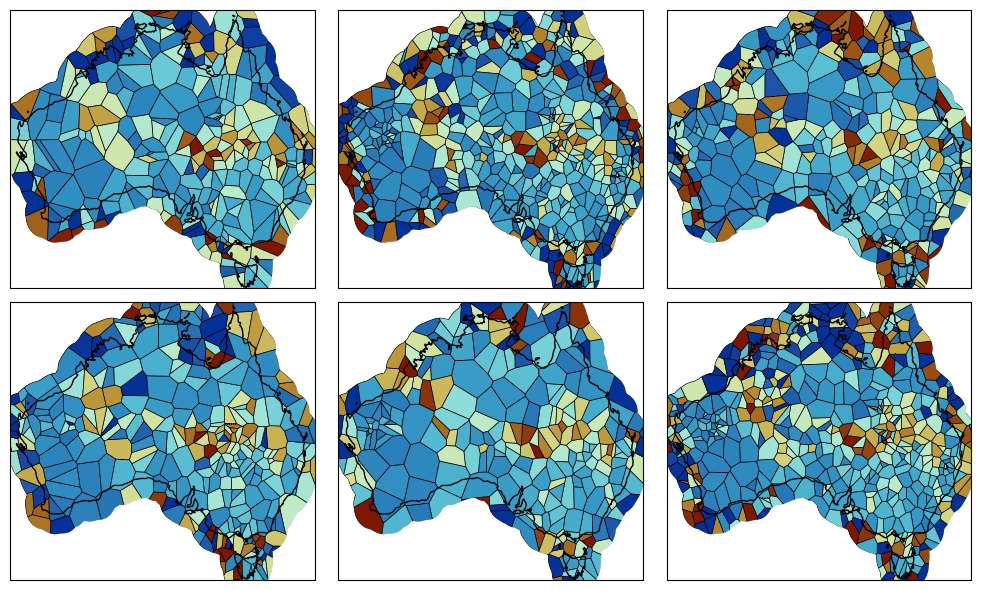

In [9]:
# Random samples with Voronoi tessellation

fig = plt.figure(figsize=(9, 6))

for i in range(1, 7):
    ax = fig.add_subplot(2, 3, i, projection=proj)
    random_index = np.random.choice(range(len(saved_states['voronoi.vel'])), 
                                    replace=False)
    voronoi_sites = saved_states['voronoi.discretization'][random_index] 
    velocity = saved_states['voronoi.vel'][random_index] 
    ax, cbar = plot_tessellation_geographic(voronoi_sites, 
                                            velocity, 
                                            ax=ax, 
                                            cmap=scm.roma, 
                                            clip_polygon=polygon,
                                            vmin=inferred_vel.min(),
                                            vmax=inferred_vel.max(),
                                            colorbar=False
                                            )
    ax.coastlines()
    ax.add_patch(PathPatch(path, 
                           facecolor='white', 
                           edgecolor='none', 
                           transform=transform, 
                           zorder=2))
    ax.set_extent(map_boundaries, crs=transform)

plt.tight_layout()
plt.show()

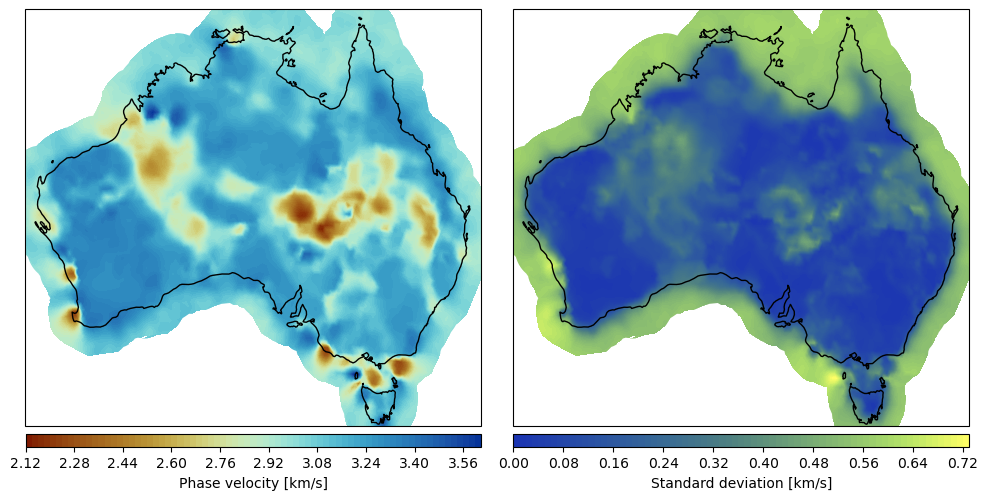

In [10]:
# Phase  Velocity and Standard Deviation Maps
fig = plt.figure(figsize=(9, 6.5))
ax1 = fig.add_subplot(1, 2, 1, projection=proj)
img = ax1.tricontourf(triang, 
                      inferred_vel, 
                      levels=75, 
                      cmap=scm.roma, 
                      transform=transform)
cbar = make_colorbar(ax1, img, orientation='horizontal', size='3%', pad='2%')
cbar.set_label('Phase velocity [km/s]')

ax2 = fig.add_subplot(1, 2, 2, projection=proj)
img = ax2.tricontourf(triang, 
                      inferred_std, 
                      levels=75, 
                      cmap=scm.imola, 
                      transform=transform)
cbar = make_colorbar(ax2, img, orientation='horizontal', size='3%', pad='2%')
cbar.set_label('Standard deviation [km/s]')


for ax in [ax1, ax2]:
    ax.coastlines()
    ax.set_extent(map_boundaries, crs=transform)
    ax.add_patch(PathPatch(path, 
                           facecolor='white', 
                           edgecolor='none', 
                           transform=transform, 
                           zorder=2))
plt.tight_layout()   
plt.show()